# EfficientNetB0 Model 

Only 2-emotional classes used for this one. 

In [23]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Custom Model Dependencies (for EfficientNet)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

### Load and Pre-process FER2013 Dataset

In [24]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

In [25]:
# Define parameters
img_size = (48, 48)
batch_size = 64
input_shape = (img_size[0], img_size[1], 3)  # 3-channel input for EfficientNetB0

## Trial #4: EfficientNetB0 Model 

### Create Data Generators 

In [26]:
# Define Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10239 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


### Load EfficientNetB0 Base

In [27]:
# Compute class weights
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

### Define the EfficientNetB0 Model

In [28]:
# Load EfficientNetB0 model (w/ ImageNet weights)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

In [29]:
# Freeze all layers (initially)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [30]:
# Create the model
model_4 = Model(inputs=base_model.input, outputs=output)

# Define loss function with label smoothing
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05) 

# Compile the model (Test 4)
model_4.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss,
              metrics=['accuracy'])
model_4.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 48, 48, 3) │          0 │ input_layer_2[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 48, 48, 3) │          7 │ rescaling_4[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 48, 48, 3) │          0 │ normalization_2[… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 24, 24,    │        512 │ block1a_se_excit

 Total params: 4,842,405 (18.47 MB)

 Trainable params: 790,274 (3.01 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

### Train the Model

#### Phase 1: Train Frozen Base

In [31]:
# Initial training (top layer only)
initial_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)
]

# Train the model
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4948 - loss: 0.8913 - val_accuracy: 0.5991 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5093 - loss: 0.7155 - val_accuracy: 0.4009 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5030 - loss: 0.7015 - val_accuracy: 0.3998 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4862 - loss: 0.6976 - val_accuracy: 0.4009 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4616 - loss: 0.6967 - val_accuracy: 0.4003 - val_loss: 0.6939 - learning_rate: 5.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4933 - loss: 0.6936 - val_accuracy: 0.4025 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4767 - loss: 0.69

#### Phase 2: Fine-Tune Top Layers

In [32]:
# Fine-tune the model (unfreeze top EfficientNetB0 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile for fine-tuning (lowered learning rate)
model_4.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss,
              metrics=['accuracy'])

# fine_tune_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
# ]

# Continue training (fine-tune entire model)
history_finetune = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.5097 - loss: 0.7080 - val_accuracy: 0.5991 - val_loss: 0.6884 - learning_rate: 1.0000e-05
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5078 - loss: 0.7077 - val_accuracy: 0.5991 - val_loss: 0.6849 - learning_rate: 1.0000e-05
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5090 - loss: 0.7021 - val_accuracy: 0.5825 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5025 - loss: 0.7025 - val_accuracy: 0.4014 - val_loss: 0.7030 - learning_rate: 1.0000e-05
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5281 - loss: 0.6965 - val_accuracy: 0.3998 - val_loss: 0.6981 - learning_rate: 1.0000e-05
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5135 - loss: 0.7000 - val_accuracy: 0.4009 - val_loss: 0.7026 - learning_rate: 5.0000e-06
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/ste

### Evaluate the Model

In [33]:
# Final evaluation (model #4)
test_loss, test_accuracy = model_4.evaluate(test_generator)
print(f"Trial Test #4 Accuracy: {test_accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8837 - loss: 0.6600
Trial Test #4 Accuracy: 0.5876


### Plot the Model on Training Histroy 

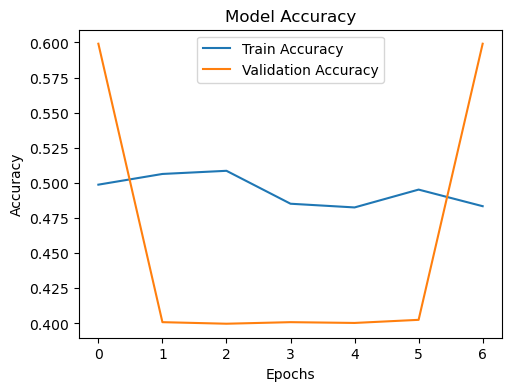

In [34]:
# Plot Accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

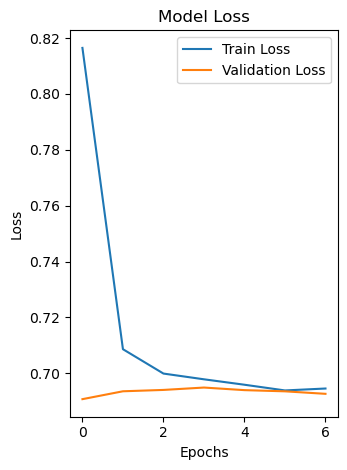

In [35]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**EfficientNetB0 with Pretrained Weights (ImageNet)** (2 classes)

Training Results:
- Accuracy: 0.8837
- Loss: 0.6600

Test Results:
- Accuracy: 0.5876
- Loss: n/a

**Question: Was this model successful?** Yes. 

**Analysis**: The training accuracy (0.8837) is very high, indicating that the model is able to fit the training data well. However, the relatively high training loss (0.6600) suggests that the model may still have room for optimization during training. The test accuracy (0.5876) is significantly lower than the training accuracy, indicating that the model is overfitting to the training data and struggling to generalize to unseen data. This performance is only slightly better than random guessing for a multi-class problem, which suggests that the model is not effectively learning the task.

**Conclusion:** EfficientNetB0 achieves high training accuracy but struggles to generalize, as evidenced by the significant drop in test accuracy. This overfitting is likely due to the small and imbalanced FER2013 dataset. Addressing these limitations through data augmentation, regularization, and fine-tuning could help improve the model's performance.